In [3]:
# https://deeplearningcourses.com/c/deep-learning-advanced-nlp
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

import os
import sys
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, SGD

import keras.backend as K
if len(K.tensorflow_backend._get_available_gpus()) > 0:
  from keras.layers import CuDNNLSTM as LSTM
  from keras.layers import CuDNNGRU as GRU

In [4]:
# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 3000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 2000
LATENT_DIM = 25

In [6]:
# load in the data
input_texts = []
target_texts = []
for line in open('/Users/tjee/machine_learning_examples/hmm_class/robert_frost.txt'):
  line = line.rstrip()
  if not line:
    continue

  input_line = '<sos> ' + line
  target_line = line + ' <eos>'

  input_texts.append(input_line)
  target_texts.append(target_line)

In [7]:
all_lines = input_texts + target_texts

In [8]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer.fit_on_texts(all_lines)
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

In [9]:
# find max seq length
max_sequence_length_from_data = max(len(s) for s in input_sequences)
print('Max sequence length:', max_sequence_length_from_data)

Max sequence length: 12


In [11]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))
assert('<sos>' in word2idx)
assert('<eos>' in word2idx)

Found 3056 unique tokens.


In [12]:
# pad sequences so that we get a N x T matrix
max_sequence_length = min(max_sequence_length_from_data, MAX_SEQUENCE_LENGTH)
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_sequence_length, padding='post')
print('Shape of data tensor:', input_sequences.shape)

Shape of data tensor: (1436, 12)


In [13]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('/Users/tjee/NLP/data_inp/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [14]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [15]:
# one-hot the targets (can't use sparse cross-entropy)
one_hot_targets = np.zeros((len(input_sequences), max_sequence_length, num_words))
for i, target_sequence in enumerate(target_sequences):
  for t, word in enumerate(target_sequence):
    if word > 0:
      one_hot_targets[i, t, word] = 1

In [16]:
# load pre-trained word embeddings into an Embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  # trainable=False
)


In [17]:
print('Building model...')

# create an LSTM network with a single LSTM
input_ = Input(shape=(max_sequence_length,))
initial_h = Input(shape=(LATENT_DIM,))
initial_c = Input(shape=(LATENT_DIM,))
x = embedding_layer(input_)
lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, _, _ = lstm(x, initial_state=[initial_h, initial_c]) # don't need the states here
dense = Dense(num_words, activation='softmax')
output = dense(x)

model = Model([input_, initial_h, initial_c], output)
model.compile(
  loss='categorical_crossentropy',
  # optimizer='rmsprop',
  optimizer=Adam(lr=0.01),
  # optimizer=SGD(lr=0.01, momentum=0.9),
  metrics=['accuracy']
)

Building model...
Instructions for updating:
Colocations handled automatically by placer.


In [18]:
print('Training model...')
z = np.zeros((len(input_sequences), LATENT_DIM))
r = model.fit(
  [input_sequences, z, z],
  one_hot_targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1148 samples, validate on 288 samples
Epoch 1/2000
1148/1148 [==============================] - 4s 3ms/step - loss: 5.3994 - acc: 0.0293 - val_loss: 5.0868 - val_acc: 0.0136
Epoch 2/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 4.6413 - acc: 0.0629 - val_loss: 4.8102 - val_acc: 0.0894
Epoch 3/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 4.3700 - acc: 0.0871 - val_loss: 4.9092 - val_acc: 0.0833
Epoch 4/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 4.2976 - acc: 0.0833 - val_loss: 4.9328 - val_acc: 0.0833
Epoch 5/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 4.2438 - acc: 0.0849 - val_loss: 4.9707 - val_acc: 0.0865
Epoch 6/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 4.2112 - acc: 0.0912 - val_loss: 4.9661 - val_acc: 

1148/1148 [==============================] - 3s 2ms/step - loss: 2.7261 - acc: 0.1997 - val_loss: 5.2129 - val_acc: 0.0987
Epoch 57/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 2.7069 - acc: 0.2009 - val_loss: 5.2229 - val_acc: 0.0943
Epoch 58/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 2.6867 - acc: 0.2043 - val_loss: 5.2339 - val_acc: 0.0978
Epoch 59/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 2.6672 - acc: 0.2065 - val_loss: 5.2357 - val_acc: 0.0972
Epoch 60/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 2.6477 - acc: 0.2092 - val_loss: 5.2476 - val_acc: 0.0961
Epoch 61/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 2.6303 - acc: 0.2123 - val_loss: 5.2549 - val_acc: 0.0964
Epoch 62/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 2.6126 - acc: 0.2139 - val_loss: 5.2660 - val_acc: 0.0972
Epoch 63/2000
1148/1148 [==============================

Epoch 116/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 2.0625 - acc: 0.2803 - val_loss: 5.7346 - val_acc: 0.0854
Epoch 117/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 2.0578 - acc: 0.2804 - val_loss: 5.7308 - val_acc: 0.0856
Epoch 118/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 2.0501 - acc: 0.2837 - val_loss: 5.7435 - val_acc: 0.0845
Epoch 119/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 2.0422 - acc: 0.2819 - val_loss: 5.7449 - val_acc: 0.0851
Epoch 120/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 2.0356 - acc: 0.2841 - val_loss: 5.7511 - val_acc: 0.0839
Epoch 121/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 2.0296 - acc: 0.2838 - val_loss: 5.7617 - val_acc: 0.0842
Epoch 122/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 2.0227 - acc: 0.2848 - val_loss: 5.7732 - val_acc: 0.0845
Epoch 123/2000
1148/1148 [========

1148/1148 [==============================] - 3s 3ms/step - loss: 1.7450 - acc: 0.3269 - val_loss: 6.0892 - val_acc: 0.0839
Epoch 176/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.7396 - acc: 0.3282 - val_loss: 6.0844 - val_acc: 0.0833
Epoch 177/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 1.7350 - acc: 0.3285 - val_loss: 6.0996 - val_acc: 0.0828
Epoch 178/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.7290 - acc: 0.3306 - val_loss: 6.1050 - val_acc: 0.0799
Epoch 179/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 1.7255 - acc: 0.3299 - val_loss: 6.1129 - val_acc: 0.0810
Epoch 180/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.7236 - acc: 0.3288 - val_loss: 6.1209 - val_acc: 0.0793
Epoch 181/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.7221 - acc: 0.3303 - val_loss: 6.1251 - val_acc: 0.0810
Epoch 182/2000
1148/1148 [=======================

1148/1148 [==============================] - 3s 2ms/step - loss: 1.5239 - acc: 0.3670 - val_loss: 6.3761 - val_acc: 0.0781
Epoch 235/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.5217 - acc: 0.3675 - val_loss: 6.3865 - val_acc: 0.0773
Epoch 236/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.5186 - acc: 0.3689 - val_loss: 6.3828 - val_acc: 0.0793
Epoch 237/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.5139 - acc: 0.3677 - val_loss: 6.3944 - val_acc: 0.0775
Epoch 238/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.5096 - acc: 0.3713 - val_loss: 6.3930 - val_acc: 0.0781
Epoch 239/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 1.5111 - acc: 0.3696 - val_loss: 6.4080 - val_acc: 0.0778
Epoch 240/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 1.5125 - acc: 0.3687 - val_loss: 6.4114 - val_acc: 0.0784
Epoch 241/2000
1148/1148 [=======================

1148/1148 [==============================] - 3s 2ms/step - loss: 1.3751 - acc: 0.3980 - val_loss: 6.6375 - val_acc: 0.0764
Epoch 294/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.3752 - acc: 0.3996 - val_loss: 6.6530 - val_acc: 0.0749
Epoch 295/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.3722 - acc: 0.3993 - val_loss: 6.6476 - val_acc: 0.0781
Epoch 296/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.3677 - acc: 0.3995 - val_loss: 6.6523 - val_acc: 0.0778
Epoch 297/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.3647 - acc: 0.4019 - val_loss: 6.6604 - val_acc: 0.0770
Epoch 298/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.3617 - acc: 0.4002 - val_loss: 6.6552 - val_acc: 0.0767
Epoch 299/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.3585 - acc: 0.4022 - val_loss: 6.6663 - val_acc: 0.0773
Epoch 300/2000
1148/1148 [=======================

1148/1148 [==============================] - 3s 2ms/step - loss: 1.2593 - acc: 0.4247 - val_loss: 6.8784 - val_acc: 0.0761
Epoch 353/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.2580 - acc: 0.4238 - val_loss: 6.8758 - val_acc: 0.0752
Epoch 354/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.2570 - acc: 0.4239 - val_loss: 6.8798 - val_acc: 0.0761
Epoch 355/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.2576 - acc: 0.4252 - val_loss: 6.8825 - val_acc: 0.0755
Epoch 356/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.2588 - acc: 0.4249 - val_loss: 6.8848 - val_acc: 0.0758
Epoch 357/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.2572 - acc: 0.4239 - val_loss: 6.8873 - val_acc: 0.0773
Epoch 358/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.2562 - acc: 0.4233 - val_loss: 6.9021 - val_acc: 0.0752
Epoch 359/2000
1148/1148 [=======================

1148/1148 [==============================] - 3s 2ms/step - loss: 1.1829 - acc: 0.4417 - val_loss: 7.0652 - val_acc: 0.0738
Epoch 412/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.1812 - acc: 0.4425 - val_loss: 7.0610 - val_acc: 0.0738
Epoch 413/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.1784 - acc: 0.4421 - val_loss: 7.0554 - val_acc: 0.0747
Epoch 414/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.1794 - acc: 0.4408 - val_loss: 7.0630 - val_acc: 0.0741
Epoch 415/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.1791 - acc: 0.4402 - val_loss: 7.0745 - val_acc: 0.0744
Epoch 416/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.1789 - acc: 0.4412 - val_loss: 7.0750 - val_acc: 0.0747
Epoch 417/2000
1148/1148 [==============================] - 4s 3ms/step - loss: 1.1787 - acc: 0.4413 - val_loss: 7.0810 - val_acc: 0.0752
Epoch 418/2000
1148/1148 [=======================

1148/1148 [==============================] - 2s 2ms/step - loss: 1.1249 - acc: 0.4546 - val_loss: 7.2265 - val_acc: 0.0741
Epoch 471/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 1.1221 - acc: 0.4552 - val_loss: 7.2423 - val_acc: 0.0712
Epoch 472/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 1.1230 - acc: 0.4552 - val_loss: 7.2365 - val_acc: 0.0741
Epoch 473/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 1.1218 - acc: 0.4542 - val_loss: 7.2439 - val_acc: 0.0718
Epoch 474/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 1.1237 - acc: 0.4541 - val_loss: 7.2488 - val_acc: 0.0720
Epoch 475/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 1.1232 - acc: 0.4556 - val_loss: 7.2407 - val_acc: 0.0723
Epoch 476/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 1.1247 - acc: 0.4530 - val_loss: 7.2609 - val_acc: 0.0718
Epoch 477/2000
1148/1148 [=======================

1148/1148 [==============================] - 2s 2ms/step - loss: 1.0807 - acc: 0.4634 - val_loss: 7.3542 - val_acc: 0.0726
Epoch 530/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 1.0792 - acc: 0.4638 - val_loss: 7.3719 - val_acc: 0.0729
Epoch 531/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 1.0769 - acc: 0.4639 - val_loss: 7.3749 - val_acc: 0.0729
Epoch 532/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 1.0797 - acc: 0.4620 - val_loss: 7.3715 - val_acc: 0.0738
Epoch 533/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 1.0744 - acc: 0.4643 - val_loss: 7.3778 - val_acc: 0.0726
Epoch 534/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 1.0728 - acc: 0.4660 - val_loss: 7.3751 - val_acc: 0.0712
Epoch 535/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.0719 - acc: 0.4654 - val_loss: 7.3818 - val_acc: 0.0720
Epoch 536/2000
1148/1148 [=======================

1148/1148 [==============================] - 3s 2ms/step - loss: 1.0416 - acc: 0.4718 - val_loss: 7.4938 - val_acc: 0.0718
Epoch 589/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.0427 - acc: 0.4703 - val_loss: 7.4896 - val_acc: 0.0718
Epoch 590/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.0398 - acc: 0.4713 - val_loss: 7.5026 - val_acc: 0.0735
Epoch 591/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.0402 - acc: 0.4696 - val_loss: 7.4941 - val_acc: 0.0712
Epoch 592/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.0363 - acc: 0.4725 - val_loss: 7.5077 - val_acc: 0.0712
Epoch 593/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.0395 - acc: 0.4718 - val_loss: 7.4983 - val_acc: 0.0720
Epoch 594/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.0423 - acc: 0.4689 - val_loss: 7.5033 - val_acc: 0.0732
Epoch 595/2000
1148/1148 [=======================

1148/1148 [==============================] - 3s 2ms/step - loss: 1.0334 - acc: 0.4699 - val_loss: 7.5962 - val_acc: 0.0689
Epoch 648/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.0332 - acc: 0.4701 - val_loss: 7.5821 - val_acc: 0.0683
Epoch 649/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.0293 - acc: 0.4710 - val_loss: 7.5896 - val_acc: 0.0680
Epoch 650/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.0257 - acc: 0.4721 - val_loss: 7.5920 - val_acc: 0.0683
Epoch 651/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.0182 - acc: 0.4768 - val_loss: 7.5833 - val_acc: 0.0692
Epoch 652/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.0126 - acc: 0.4760 - val_loss: 7.5796 - val_acc: 0.0674
Epoch 653/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.0080 - acc: 0.4776 - val_loss: 7.5835 - val_acc: 0.0686
Epoch 654/2000
1148/1148 [=======================

1148/1148 [==============================] - 2s 2ms/step - loss: 0.9842 - acc: 0.4803 - val_loss: 7.6756 - val_acc: 0.0660
Epoch 707/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9797 - acc: 0.4846 - val_loss: 7.6670 - val_acc: 0.0668
Epoch 708/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9794 - acc: 0.4847 - val_loss: 7.6751 - val_acc: 0.0654
Epoch 709/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9761 - acc: 0.4835 - val_loss: 7.6700 - val_acc: 0.0657
Epoch 710/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9715 - acc: 0.4856 - val_loss: 7.6652 - val_acc: 0.0671
Epoch 711/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9707 - acc: 0.4879 - val_loss: 7.6745 - val_acc: 0.0674
Epoch 712/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9686 - acc: 0.4866 - val_loss: 7.6683 - val_acc: 0.0666
Epoch 713/2000
1148/1148 [=======================

1148/1148 [==============================] - 3s 3ms/step - loss: 0.9526 - acc: 0.4888 - val_loss: 7.7883 - val_acc: 0.0657
Epoch 766/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.9545 - acc: 0.4872 - val_loss: 7.7827 - val_acc: 0.0648
Epoch 767/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.9562 - acc: 0.4872 - val_loss: 7.7853 - val_acc: 0.0674
Epoch 768/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.9513 - acc: 0.4903 - val_loss: 7.7758 - val_acc: 0.0657
Epoch 769/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.9500 - acc: 0.4911 - val_loss: 7.7824 - val_acc: 0.0663
Epoch 770/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.9494 - acc: 0.4901 - val_loss: 7.7832 - val_acc: 0.0660
Epoch 771/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.9491 - acc: 0.4922 - val_loss: 7.7895 - val_acc: 0.0660
Epoch 772/2000
1148/1148 [=======================

1148/1148 [==============================] - 2s 2ms/step - loss: 0.9514 - acc: 0.4890 - val_loss: 7.8752 - val_acc: 0.0660
Epoch 825/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9504 - acc: 0.4877 - val_loss: 7.8682 - val_acc: 0.0686
Epoch 826/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9617 - acc: 0.4857 - val_loss: 7.8546 - val_acc: 0.0651
Epoch 827/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9537 - acc: 0.4884 - val_loss: 7.8521 - val_acc: 0.0645
Epoch 828/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9485 - acc: 0.4890 - val_loss: 7.8586 - val_acc: 0.0657
Epoch 829/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9428 - acc: 0.4910 - val_loss: 7.8698 - val_acc: 0.0645
Epoch 830/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9372 - acc: 0.4940 - val_loss: 7.8495 - val_acc: 0.0660
Epoch 831/2000
1148/1148 [=======================

1148/1148 [==============================] - 2s 2ms/step - loss: 0.9123 - acc: 0.4999 - val_loss: 7.8928 - val_acc: 0.0668
Epoch 884/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9118 - acc: 0.4993 - val_loss: 7.9089 - val_acc: 0.0663
Epoch 885/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9104 - acc: 0.4986 - val_loss: 7.9100 - val_acc: 0.0660
Epoch 886/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9101 - acc: 0.4995 - val_loss: 7.9112 - val_acc: 0.0660
Epoch 887/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9100 - acc: 0.5001 - val_loss: 7.9133 - val_acc: 0.0666
Epoch 888/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9089 - acc: 0.5001 - val_loss: 7.9199 - val_acc: 0.0657
Epoch 889/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9099 - acc: 0.4996 - val_loss: 7.9066 - val_acc: 0.0677
Epoch 890/2000
1148/1148 [=======================

1148/1148 [==============================] - 2s 2ms/step - loss: 0.8926 - acc: 0.5033 - val_loss: 8.0098 - val_acc: 0.0657
Epoch 943/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8939 - acc: 0.5048 - val_loss: 7.9885 - val_acc: 0.0651
Epoch 944/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8988 - acc: 0.5020 - val_loss: 7.9736 - val_acc: 0.0666
Epoch 945/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9017 - acc: 0.4989 - val_loss: 8.0025 - val_acc: 0.0634
Epoch 946/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9029 - acc: 0.5004 - val_loss: 7.9836 - val_acc: 0.0634
Epoch 947/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9073 - acc: 0.4980 - val_loss: 7.9788 - val_acc: 0.0657
Epoch 948/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9087 - acc: 0.4999 - val_loss: 7.9972 - val_acc: 0.0648
Epoch 949/2000
1148/1148 [=======================

1148/1148 [==============================] - 2s 2ms/step - loss: 0.8777 - acc: 0.5071 - val_loss: 8.0223 - val_acc: 0.0622
Epoch 1002/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8756 - acc: 0.5081 - val_loss: 8.0237 - val_acc: 0.0628
Epoch 1003/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8786 - acc: 0.5072 - val_loss: 8.0192 - val_acc: 0.0616
Epoch 1004/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8792 - acc: 0.5056 - val_loss: 8.0159 - val_acc: 0.0616
Epoch 1005/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8791 - acc: 0.5057 - val_loss: 8.0292 - val_acc: 0.0634
Epoch 1006/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8819 - acc: 0.5041 - val_loss: 8.0352 - val_acc: 0.0622
Epoch 1007/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8890 - acc: 0.5032 - val_loss: 8.0201 - val_acc: 0.0613
Epoch 1008/2000
1148/1148 [================

1148/1148 [==============================] - 2s 2ms/step - loss: 0.8880 - acc: 0.5025 - val_loss: 8.0687 - val_acc: 0.0608
Epoch 1061/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8824 - acc: 0.5061 - val_loss: 8.0994 - val_acc: 0.0613
Epoch 1062/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8815 - acc: 0.5037 - val_loss: 8.1017 - val_acc: 0.0625
Epoch 1063/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8778 - acc: 0.5069 - val_loss: 8.1073 - val_acc: 0.0622
Epoch 1064/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8737 - acc: 0.5063 - val_loss: 8.0892 - val_acc: 0.0622
Epoch 1065/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8731 - acc: 0.5081 - val_loss: 8.0944 - val_acc: 0.0616
Epoch 1066/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8748 - acc: 0.5070 - val_loss: 8.0804 - val_acc: 0.0613
Epoch 1067/2000
1148/1148 [================

1148/1148 [==============================] - 2s 2ms/step - loss: 0.8701 - acc: 0.5072 - val_loss: 8.1199 - val_acc: 0.0631
Epoch 1120/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8712 - acc: 0.5054 - val_loss: 8.1214 - val_acc: 0.0611
Epoch 1121/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8729 - acc: 0.5055 - val_loss: 8.1315 - val_acc: 0.0631
Epoch 1122/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8695 - acc: 0.5069 - val_loss: 8.1319 - val_acc: 0.0619
Epoch 1123/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8727 - acc: 0.5051 - val_loss: 8.1234 - val_acc: 0.0625
Epoch 1124/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8695 - acc: 0.5076 - val_loss: 8.1180 - val_acc: 0.0622
Epoch 1125/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8664 - acc: 0.5068 - val_loss: 8.1249 - val_acc: 0.0625
Epoch 1126/2000
1148/1148 [================

1148/1148 [==============================] - 2s 2ms/step - loss: 0.8742 - acc: 0.5049 - val_loss: 8.1423 - val_acc: 0.0637
Epoch 1179/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8721 - acc: 0.5026 - val_loss: 8.1438 - val_acc: 0.0642
Epoch 1180/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8671 - acc: 0.5082 - val_loss: 8.1532 - val_acc: 0.0648
Epoch 1181/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8667 - acc: 0.5054 - val_loss: 8.1402 - val_acc: 0.0631
Epoch 1182/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8723 - acc: 0.5030 - val_loss: 8.1467 - val_acc: 0.0654
Epoch 1183/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8757 - acc: 0.5048 - val_loss: 8.1348 - val_acc: 0.0651
Epoch 1184/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8846 - acc: 0.5004 - val_loss: 8.1542 - val_acc: 0.0628
Epoch 1185/2000
1148/1148 [================

1148/1148 [==============================] - 2s 2ms/step - loss: 0.8526 - acc: 0.5091 - val_loss: 8.2104 - val_acc: 0.0599
Epoch 1238/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8608 - acc: 0.5078 - val_loss: 8.1996 - val_acc: 0.0619
Epoch 1239/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8993 - acc: 0.4946 - val_loss: 8.1866 - val_acc: 0.0622
Epoch 1240/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9237 - acc: 0.4903 - val_loss: 8.1992 - val_acc: 0.0616
Epoch 1241/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9319 - acc: 0.4861 - val_loss: 8.1981 - val_acc: 0.0637
Epoch 1242/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9344 - acc: 0.4857 - val_loss: 8.2098 - val_acc: 0.0593
Epoch 1243/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9206 - acc: 0.4887 - val_loss: 8.1739 - val_acc: 0.0648
Epoch 1244/2000
1148/1148 [================

1148/1148 [==============================] - 2s 2ms/step - loss: 0.8207 - acc: 0.5195 - val_loss: 8.2421 - val_acc: 0.0651
Epoch 1297/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8212 - acc: 0.5201 - val_loss: 8.2222 - val_acc: 0.0639
Epoch 1298/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8273 - acc: 0.5173 - val_loss: 8.2300 - val_acc: 0.0625
Epoch 1299/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8313 - acc: 0.5161 - val_loss: 8.2198 - val_acc: 0.0645
Epoch 1300/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8369 - acc: 0.5128 - val_loss: 8.2312 - val_acc: 0.0651
Epoch 1301/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8509 - acc: 0.5113 - val_loss: 8.2095 - val_acc: 0.0671
Epoch 1302/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8435 - acc: 0.5120 - val_loss: 8.2030 - val_acc: 0.0660
Epoch 1303/2000
1148/1148 [================

1148/1148 [==============================] - 2s 2ms/step - loss: 0.8277 - acc: 0.5175 - val_loss: 8.2227 - val_acc: 0.0651
Epoch 1356/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8256 - acc: 0.5173 - val_loss: 8.2054 - val_acc: 0.0654
Epoch 1357/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8237 - acc: 0.5177 - val_loss: 8.2165 - val_acc: 0.0660
Epoch 1358/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8221 - acc: 0.5179 - val_loss: 8.2121 - val_acc: 0.0660
Epoch 1359/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8206 - acc: 0.5187 - val_loss: 8.2170 - val_acc: 0.0642
Epoch 1360/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8214 - acc: 0.5192 - val_loss: 8.2217 - val_acc: 0.0657
Epoch 1361/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8215 - acc: 0.5189 - val_loss: 8.2344 - val_acc: 0.0648
Epoch 1362/2000
1148/1148 [================

1148/1148 [==============================] - 2s 2ms/step - loss: 0.8606 - acc: 0.5064 - val_loss: 8.2637 - val_acc: 0.0605
Epoch 1415/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8551 - acc: 0.5089 - val_loss: 8.2800 - val_acc: 0.0602
Epoch 1416/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8518 - acc: 0.5092 - val_loss: 8.2634 - val_acc: 0.0619
Epoch 1417/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8489 - acc: 0.5097 - val_loss: 8.2579 - val_acc: 0.0608
Epoch 1418/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8421 - acc: 0.5119 - val_loss: 8.2686 - val_acc: 0.0599
Epoch 1419/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8374 - acc: 0.5127 - val_loss: 8.2537 - val_acc: 0.0611
Epoch 1420/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8323 - acc: 0.5137 - val_loss: 8.2743 - val_acc: 0.0611
Epoch 1421/2000
1148/1148 [================

1148/1148 [==============================] - 2s 2ms/step - loss: 0.8295 - acc: 0.5152 - val_loss: 8.2926 - val_acc: 0.0642
Epoch 1474/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8263 - acc: 0.5147 - val_loss: 8.2778 - val_acc: 0.0634
Epoch 1475/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8231 - acc: 0.5167 - val_loss: 8.2938 - val_acc: 0.0616
Epoch 1476/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8217 - acc: 0.5166 - val_loss: 8.2757 - val_acc: 0.0637
Epoch 1477/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8217 - acc: 0.5170 - val_loss: 8.3168 - val_acc: 0.0608
Epoch 1478/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8288 - acc: 0.5129 - val_loss: 8.2735 - val_acc: 0.0625
Epoch 1479/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8307 - acc: 0.5144 - val_loss: 8.2709 - val_acc: 0.0634
Epoch 1480/2000
1148/1148 [================

1148/1148 [==============================] - 2s 2ms/step - loss: 0.7986 - acc: 0.5198 - val_loss: 8.3122 - val_acc: 0.0613
Epoch 1533/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7976 - acc: 0.5225 - val_loss: 8.3015 - val_acc: 0.0654
Epoch 1534/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7961 - acc: 0.5228 - val_loss: 8.3142 - val_acc: 0.0611
Epoch 1535/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7972 - acc: 0.5237 - val_loss: 8.3075 - val_acc: 0.0637
Epoch 1536/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7963 - acc: 0.5234 - val_loss: 8.3113 - val_acc: 0.0637
Epoch 1537/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7956 - acc: 0.5199 - val_loss: 8.3094 - val_acc: 0.0634
Epoch 1538/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7945 - acc: 0.5236 - val_loss: 8.3276 - val_acc: 0.0631
Epoch 1539/2000
1148/1148 [================

1148/1148 [==============================] - 2s 2ms/step - loss: 0.7954 - acc: 0.5226 - val_loss: 8.3355 - val_acc: 0.0605
Epoch 1592/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7937 - acc: 0.5245 - val_loss: 8.3332 - val_acc: 0.0611
Epoch 1593/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7946 - acc: 0.5235 - val_loss: 8.3397 - val_acc: 0.0593
Epoch 1594/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7944 - acc: 0.5238 - val_loss: 8.3544 - val_acc: 0.0596
Epoch 1595/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7991 - acc: 0.5228 - val_loss: 8.3408 - val_acc: 0.0602
Epoch 1596/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7993 - acc: 0.5231 - val_loss: 8.3351 - val_acc: 0.0637
Epoch 1597/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7987 - acc: 0.5223 - val_loss: 8.3256 - val_acc: 0.0608
Epoch 1598/2000
1148/1148 [================

1148/1148 [==============================] - 2s 2ms/step - loss: 0.7919 - acc: 0.5245 - val_loss: 8.3629 - val_acc: 0.0613
Epoch 1651/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7955 - acc: 0.5214 - val_loss: 8.3638 - val_acc: 0.0634
Epoch 1652/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7938 - acc: 0.5205 - val_loss: 8.3736 - val_acc: 0.0619
Epoch 1653/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7905 - acc: 0.5250 - val_loss: 8.3758 - val_acc: 0.0613
Epoch 1654/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7878 - acc: 0.5253 - val_loss: 8.3678 - val_acc: 0.0616
Epoch 1655/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7871 - acc: 0.5251 - val_loss: 8.3658 - val_acc: 0.0613
Epoch 1656/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7852 - acc: 0.5260 - val_loss: 8.3734 - val_acc: 0.0613
Epoch 1657/2000
1148/1148 [================

1148/1148 [==============================] - 2s 2ms/step - loss: 0.7909 - acc: 0.5225 - val_loss: 8.3776 - val_acc: 0.0613
Epoch 1710/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7885 - acc: 0.5251 - val_loss: 8.3851 - val_acc: 0.0611
Epoch 1711/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7880 - acc: 0.5248 - val_loss: 8.3740 - val_acc: 0.0608
Epoch 1712/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7875 - acc: 0.5256 - val_loss: 8.3759 - val_acc: 0.0619
Epoch 1713/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7829 - acc: 0.5266 - val_loss: 8.3767 - val_acc: 0.0619
Epoch 1714/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7825 - acc: 0.5241 - val_loss: 8.3744 - val_acc: 0.0619
Epoch 1715/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7787 - acc: 0.5268 - val_loss: 8.3675 - val_acc: 0.0619
Epoch 1716/2000
1148/1148 [================

1148/1148 [==============================] - 2s 2ms/step - loss: 0.8045 - acc: 0.5203 - val_loss: 8.3917 - val_acc: 0.0634
Epoch 1769/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8075 - acc: 0.5179 - val_loss: 8.3645 - val_acc: 0.0666
Epoch 1770/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8067 - acc: 0.5188 - val_loss: 8.4041 - val_acc: 0.0625
Epoch 1771/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8112 - acc: 0.5173 - val_loss: 8.3645 - val_acc: 0.0639
Epoch 1772/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8238 - acc: 0.5158 - val_loss: 8.3808 - val_acc: 0.0651
Epoch 1773/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8309 - acc: 0.5131 - val_loss: 8.3747 - val_acc: 0.0645
Epoch 1774/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8385 - acc: 0.5105 - val_loss: 8.3983 - val_acc: 0.0663
Epoch 1775/2000
1148/1148 [================

1148/1148 [==============================] - 2s 2ms/step - loss: 0.7789 - acc: 0.5264 - val_loss: 8.4277 - val_acc: 0.0619
Epoch 1828/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7777 - acc: 0.5265 - val_loss: 8.4311 - val_acc: 0.0637
Epoch 1829/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7755 - acc: 0.5278 - val_loss: 8.4187 - val_acc: 0.0619
Epoch 1830/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7777 - acc: 0.5274 - val_loss: 8.4172 - val_acc: 0.0602
Epoch 1831/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7742 - acc: 0.5290 - val_loss: 8.4225 - val_acc: 0.0625
Epoch 1832/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7719 - acc: 0.5294 - val_loss: 8.4298 - val_acc: 0.0608
Epoch 1833/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7716 - acc: 0.5301 - val_loss: 8.4252 - val_acc: 0.0611
Epoch 1834/2000
1148/1148 [================

1148/1148 [==============================] - 2s 2ms/step - loss: 0.7935 - acc: 0.5218 - val_loss: 8.4244 - val_acc: 0.0605
Epoch 1887/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7881 - acc: 0.5242 - val_loss: 8.4334 - val_acc: 0.0582
Epoch 1888/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7823 - acc: 0.5264 - val_loss: 8.4205 - val_acc: 0.0599
Epoch 1889/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7796 - acc: 0.5270 - val_loss: 8.4261 - val_acc: 0.0582
Epoch 1890/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7805 - acc: 0.5256 - val_loss: 8.4185 - val_acc: 0.0570
Epoch 1891/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7782 - acc: 0.5257 - val_loss: 8.4159 - val_acc: 0.0605
Epoch 1892/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7778 - acc: 0.5265 - val_loss: 8.4444 - val_acc: 0.0576
Epoch 1893/2000
1148/1148 [================

1148/1148 [==============================] - 2s 2ms/step - loss: 0.7654 - acc: 0.5301 - val_loss: 8.4459 - val_acc: 0.0596
Epoch 1946/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7655 - acc: 0.5295 - val_loss: 8.4388 - val_acc: 0.0590
Epoch 1947/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7648 - acc: 0.5306 - val_loss: 8.4517 - val_acc: 0.0596
Epoch 1948/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7630 - acc: 0.5302 - val_loss: 8.4383 - val_acc: 0.0596
Epoch 1949/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7648 - acc: 0.5300 - val_loss: 8.4469 - val_acc: 0.0605
Epoch 1950/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7651 - acc: 0.5281 - val_loss: 8.4597 - val_acc: 0.0593
Epoch 1951/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7646 - acc: 0.5309 - val_loss: 8.4519 - val_acc: 0.0590
Epoch 1952/2000
1148/1148 [================

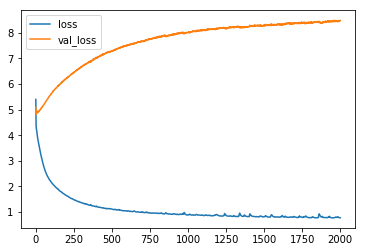

In [19]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

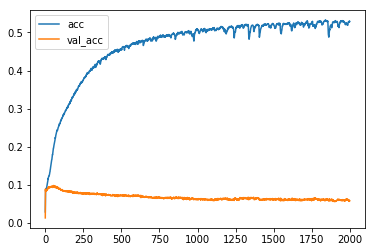

In [20]:
# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [21]:
# make a sampling model
input2 = Input(shape=(1,)) # we'll only input one word at a time
x = embedding_layer(input2)
x, h, c = lstm(x, initial_state=[initial_h, initial_c]) # now we need states to feed back in
output2 = dense(x)
sampling_model = Model([input2, initial_h, initial_c], [output2, h, c])

In [22]:
# reverse word2idx dictionary to get back words
# during prediction
idx2word = {v:k for k, v in word2idx.items()}

In [23]:
def sample_line():
  # initial inputs
  np_input = np.array([[ word2idx['<sos>'] ]])
  h = np.zeros((1, LATENT_DIM))
  c = np.zeros((1, LATENT_DIM))

  # so we know when to quit
  eos = word2idx['<eos>']

  # store the output here
  output_sentence = []

  for _ in range(max_sequence_length):
    o, h, c = sampling_model.predict([np_input, h, c])

    # print("o.shape:", o.shape, o[0,0,:10])
    # idx = np.argmax(o[0,0])
    probs = o[0,0]
    if np.argmax(probs) == 0:
      print("wtf")
    probs[0] = 0
    probs /= probs.sum()
    idx = np.random.choice(len(probs), p=probs)
    if idx == eos:
      break

    # accuulate output
    output_sentence.append(idx2word.get(idx, '<WTF %s>' % idx))

    # make the next input into model
    np_input[0,0] = idx

  return ' '.join(output_sentence)

In [24]:
# generate a 4 line poem
while True:
  for _ in range(4):
    print(sample_line())

  ans = input("---generate another? [Y/n]---")
  if ans and ans[0].lower().startswith('n'):
    break

time someone about when what i've come on the cellar wall
it was the bones. i knew them - and left me,
this was no playhouse but what a chimney clear made them do
waiting for things to hurt me now they are.
---generate another? [Y/n]---Y
a single leaf was on a bough,
the mica sheets were big as plate-glass windows.
drawn into town a thing,
in leaves no step had trodden black.
---generate another? [Y/n]---n
